# Single Photon Counting with FastCCD and CSXTOOLS

## First some imports, using csxtools

In [1]:
import numpy as np
import tifffile

%matplotlib notebook
from matplotlib import pyplot as plt

from databroker import DataBroker as db

from csxtools.fastccd import phocount
from csxtools import make_panel_plot
from csxtools.utils import get_fastccd_images, get_images_to_3D
from csxtools.ipynb import image_stack_to_movie, show_image_stack
import timeit

## Function definitions

In [2]:
def get_photons(data):
    results = []
    histograms = []

    for n in range(1, 9):
        c = phocount.photon_count(data, (75,250), (0, 500), (0, 100), n, True)
        h = np.histogram(c[0], bins=100, range=(50, 350))
        results.append(c[0].ravel())
        histograms.append(h[0]) 
    
    hist_x = h[1][:-1]
    results = np.array(results)
    histograms = np.array(histograms)
    
    return (results, hist_x, histograms)


def plot_results(results, hist_x, histograms):
    color=iter(plt.cm.rainbow(np.linspace(0,1,9)))

    plt.subplot(121)
    for x,h in enumerate(histograms):
        plt.plot(hist_x, h, 'o-', c=next(color), label='{}'.format(x+1))
    plt.legend()

    m = np.nanmean(results, axis=1)
    s = np.nanstd(results, axis=1)
    
    ax1 = plt.subplot(122)
    ax1.plot(np.arange(1, 9), m,'bo')
    ax1.set_xlabel('ESUM Value')
    ax1.set_ylabel('Mean Integrated ADU')

    ax2 = ax1.twinx()
    ax2.plot(np.arange(1, 9), s,'rs')
    ax2.set_ylabel('Standard Deviation')

## Make a flat image to mask the data

/GPFS/xf23id/users/swilkins/miniconda3/envs/analysis/lib/python3.5/site-packages/IPython/kernel/__main__.py:2: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  from ipykernel import kernelapp as app


<IPython.core.display.Javascript object>


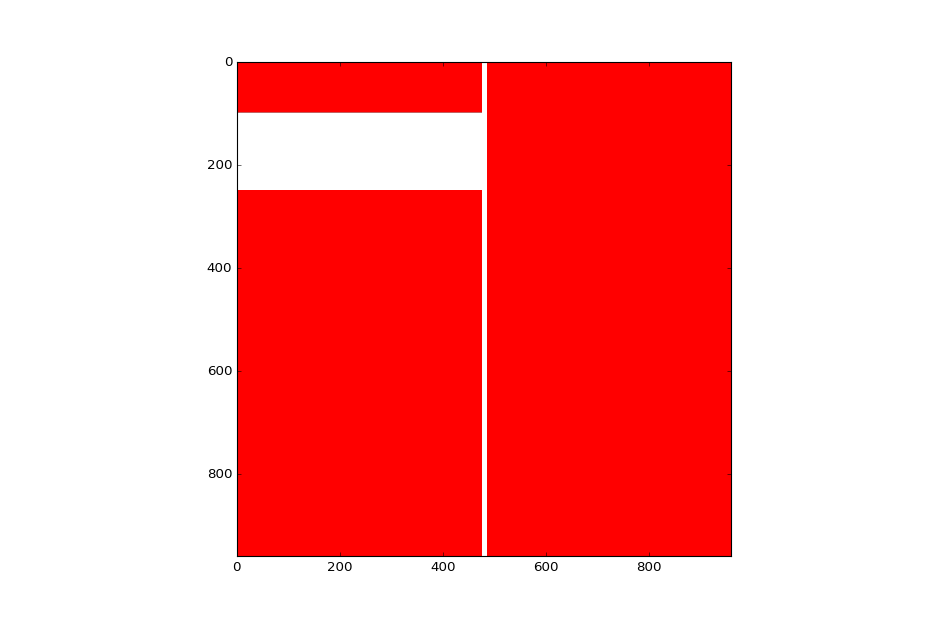

In [3]:
flat = np.ones((960, 960))
flat[100:250,0:(960/2)] = np.nan
flat[:,475:485] = np.nan
plt.figure()
plt.imshow(flat, cmap='prism')

flat = np.rot90(flat)

## Load the data
Using test data from a run at CSX

In [4]:
dark = db[59261]
light = db[59263, 59264, 59265, 59266, 59267, 59268]
images = get_fastccd_images(light, (dark, None, None), flat=flat)
stack = get_images_to_3D(images)

## Check the data

<IPython.core.display.Javascript object>


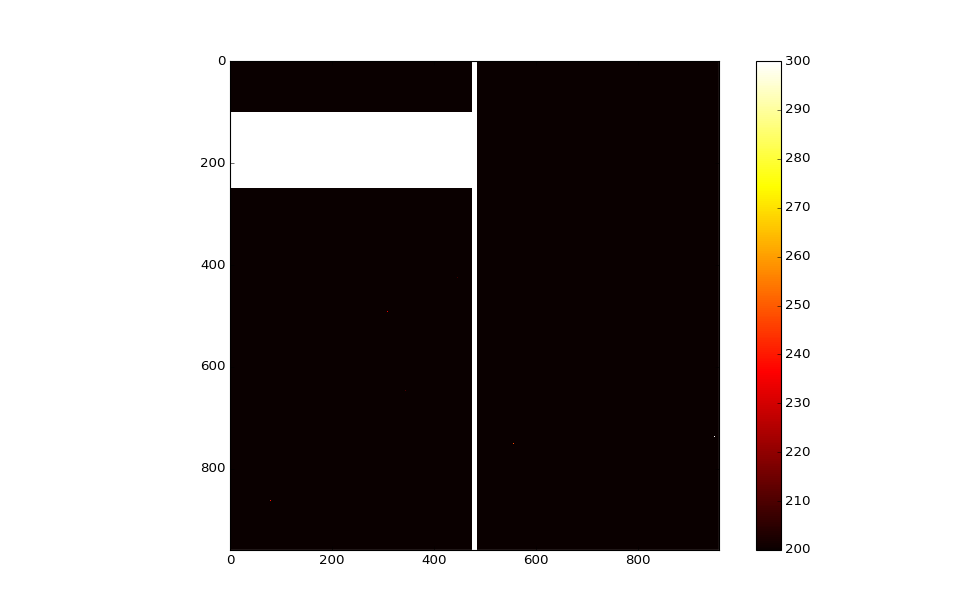

In [5]:
plt.figure()
plt.imshow(stack[0], vmin=200, vmax=300, cmap='hot', interpolation='none')
plt.colorbar()

<IPython.core.display.Javascript object>


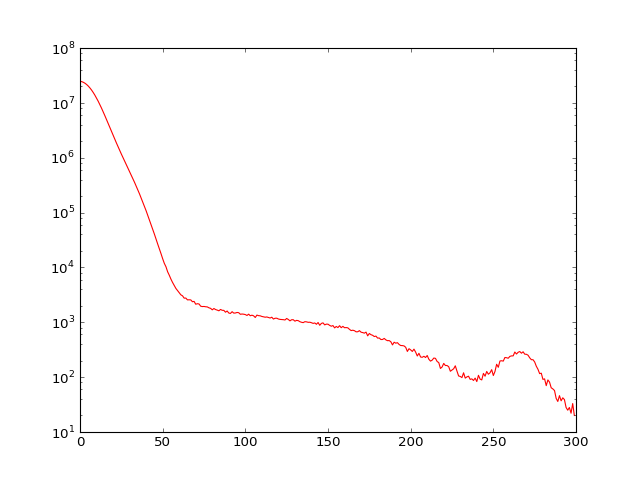

In [6]:
h = np.histogram(stack.ravel(), bins=300, range=(0, 300))
fig, ax = plt.subplots()
ax.semilogy(h[1][:-1], h[0], 'r-')

## Run a loop to generate data for diferent ESUM

In [7]:
results, hist_x, histograms = get_photons(stack)

## Plot a histogram of integrated ADUs 

<IPython.core.display.Javascript object>


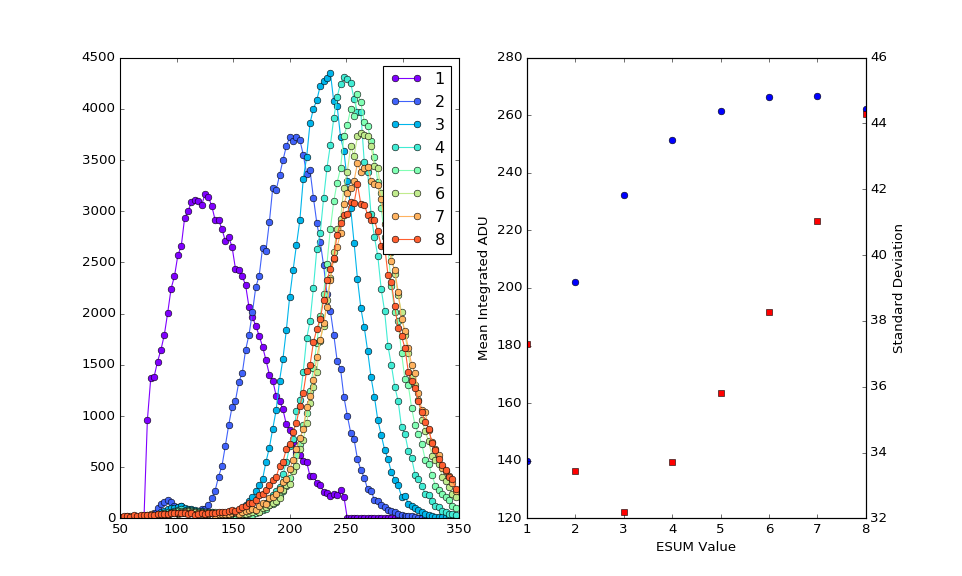

In [8]:
plt.figure()
plot_results(results, hist_x, histograms)

## Flatfield Correction

Now generate a flatfield correction based on the mean per column. 

In [9]:
c = phocount.photon_count(stack, (75,250), (200, 350), (24, 70), 5, True)
inti = c[0][:,:,480:]
stdi = c[1][:,:,480:]
#inti[:,:,0::10] = np.nan
#inti[:,:,9::10] = np.nan
ff = np.nanmean(inti, axis=(0,2))
ffstd = np.nanstd(inti, axis=(0,2))
ffn = np.nansum(inti > 100, axis=(0,2))
ggstd = np.nanmean(stdi, axis=(0,2))

/GPFS/xf23id/users/swilkins/miniconda3/envs/analysis/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/GPFS/xf23id/users/swilkins/miniconda3/envs/analysis/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:1136: RuntimeWarning: Degrees of freedom <= 0 for slice.
  warnings.warn("Degrees of freedom <= 0 for slice.", RuntimeWarning)
/GPFS/xf23id/users/swilkins/miniconda3/envs/analysis/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


<IPython.core.display.Javascript object>


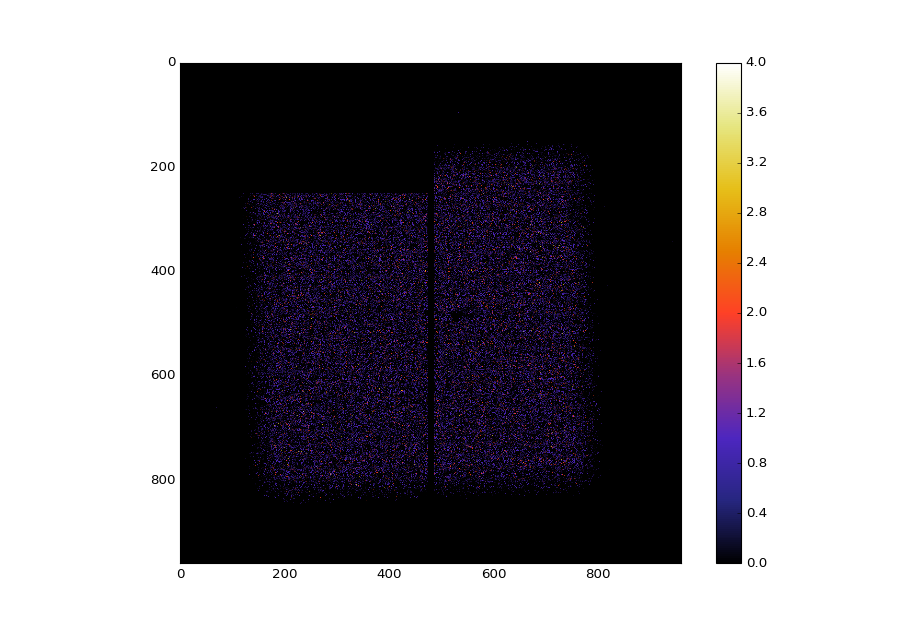

In [14]:
fig, ax = plt.subplots()
cax = ax.imshow(np.nansum(c[0] > 100, axis=0), cmap='CMRmap')
cbar = fig.colorbar(cax)

<IPython.core.display.Javascript object>


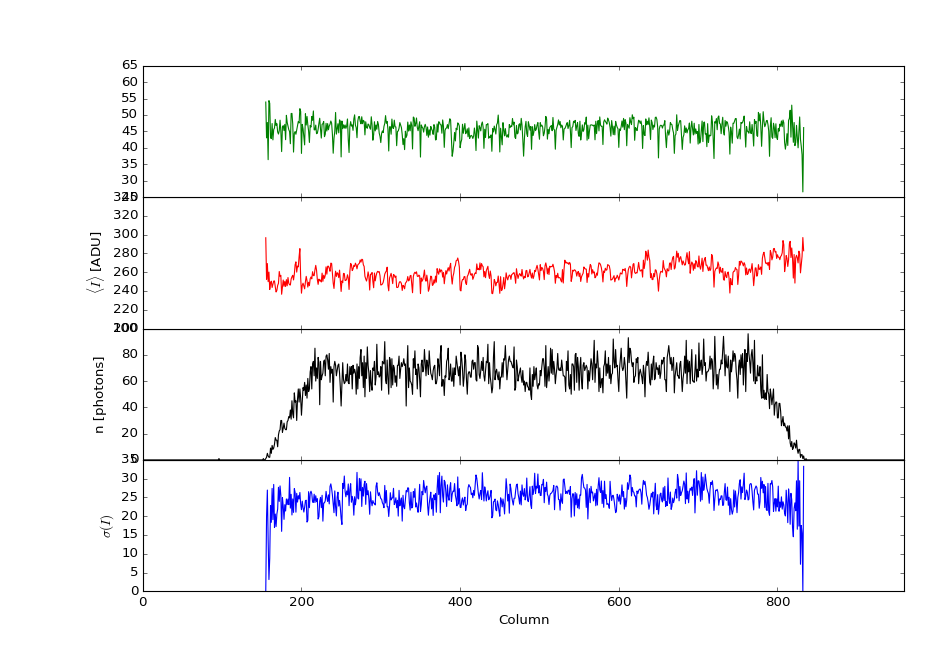

In [11]:
fig = plt.figure()
ax = make_panel_plot(n=4, fig=fig)

ax[3].plot(ggstd, 'g')
ax[2].plot(ff, 'r-')
ax[1].plot(ffn, 'k-')
ax[0].plot(ffstd, 'b-')

ax[2].set_ylabel(r'$\leftangle I \rightangle$ [ADU]')
ax[2].set_title('Results by column ')
ax[1].set_ylabel('n [photons]')
ax[0].set_ylabel('$\sigma (I)$')
ax[0].set_xlabel('Column')

for a in ax:
    a.set_xlim((0,960))

<IPython.core.display.Javascript object>


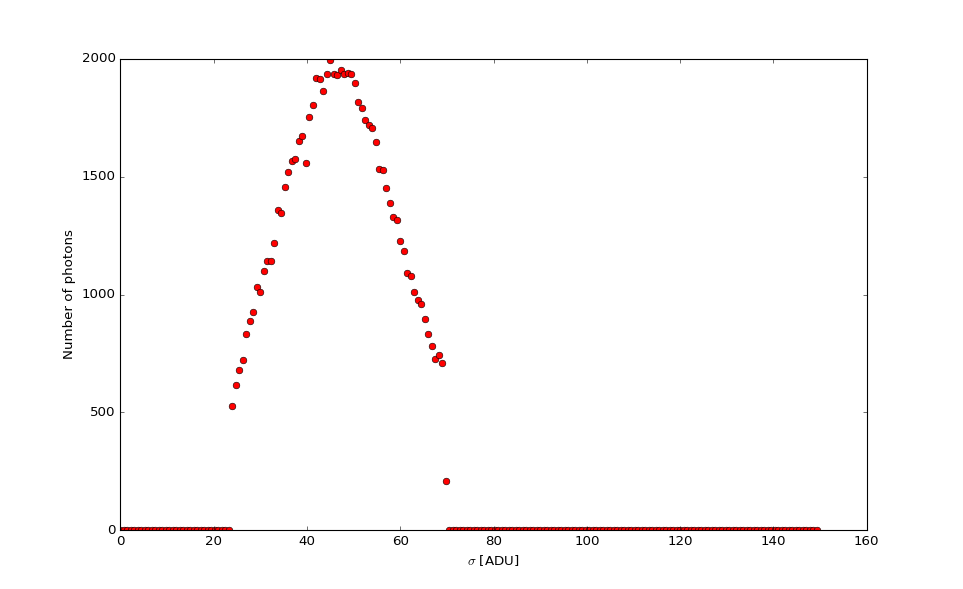

In [15]:
hist = np.histogram(c[1], bins=200, range=(0,150))
fig, ax = plt.subplots()
ax.plot(hist[1][:-1], hist[0], 'ro')
ax.set_xlabel('$\sigma$ [ADU]')
ax.set_ylabel('Number of photons')

In [16]:
import csxtools
csxtools.__version__

'0.1.8+2.g5c8a0d6.dirty'